In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
raw_dir="data/raw/Transactions Data"

In [4]:
# Joining files in single table

frames = []

for filename in os.listdir(raw_dir):
    f = os.path.join(raw_dir, filename)
    print(f)
    # checking if it is a file
    if "detalhado" in f and ".xlsx" in f:
        df = pd.read_excel(f)
        frames.append(df)

data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220718.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220412.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_202110_20220222.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_Agregado_2020_01_2021_11.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220613.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220511.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220818.xlsx
data/raw/Transactions Data/SIBS_Analytics_Freguesias_detalhado_20220310.xlsx


In [5]:
result = pd.concat(frames)

In [6]:
result

,Ano/Mês,Tipo de dia,País do cartão,Setor,Freguesia,Nº de operações,Valor das operações
0,Abr 22,Dia da Semana,Andorra,"Imprensa, Livraria e Papelaria","União das freguesias de Cedofeita, Santo Ildef...",16,343.29
1,Abr 22,Dia da Semana,Andorra,Grandes Superficies focadas em alimentação,"União das freguesias de Cedofeita, Santo Ildef...",18,262.36
2,Abr 22,Dia da Semana,Andorra,Hoteis e Resorts,ARU/ORU do Centro Histórico,15,2259.86
3,Abr 22,Dia da Semana,Andorra,Hoteis e Resorts,"União das freguesias de Cedofeita, Santo Ildef...",19,2815.76
4,Abr 22,Dia da Semana,Andorra,Restaurantes,ARU/ORU do Centro Histórico,34,824.20
...,...,...,...,...,...,...,...
10729,Fev 22,Fim de Semana,Estados Unidos Da America,Levantamentos,"União das freguesias de Aldoar, Foz do Douro e...",25,3610.00
10730,Fev 22,Fim de Semana,Estados Unidos Da America,Levantamentos,"União das freguesias de Cedofeita, Santo Ildef...",268,37130.00
10731,Fev 22,Fim de Semana,Estados Unidos Da America,Levantamentos,União das freguesias de Lordelo do Ouro e Mass...,28,4100.00
10732,Fev 22,Fim de Semana,Bielorussia,Grandes Superficies focadas em alimentação,"União das freguesias de Cedofeita, Santo Ildef...",20,266.11


In [7]:
def replace_origin_local(row):
    if row['País do cartão'] == 'Portugal':
        return 'local'
    else:
        return 'non-local'

In [8]:
result['origin'] = result.apply(lambda row: replace_origin_local(row), axis=1)

In [9]:
result_monthly = result.groupby(['origin', 'Setor', 'Freguesia',
                                                   'Ano/Mês'], as_index=False).sum()

In [10]:
result_monthly = result_monthly[(result_monthly["Setor"] == "Restaurantes") | (result_monthly["Setor"]=="Bares, Cafés e Similares")]

In [11]:
result_monthly.reset_index(inplace=True)

In [12]:
def calculate_prob(row, df):
    """
    Calculates probability of operation being done by a local
    or non-local in a given sector, freguesia, and date
    """
    setor = row['Setor']
    freguesia = row['Freguesia']
    date = row['Ano/Mês']

    if row['origin'] == 'local':
        reverse_origin = 'non-local'
    else:
        reverse_origin = 'local'

    condition = (df['origin'] == reverse_origin) & (df['Setor'] == setor) & \
            (df['Freguesia'] == freguesia) & (df['Ano/Mês'] == date)

    try:
        reverse_origin_transactions = df[condition]['Nº de operações'].values[0]
    except IndexError:
        reverse_origin_transactions = 0

    ratio = row['Nº de operações']/(row['Nº de operações'] + reverse_origin_transactions)

    # print(ratio)

    return ratio

In [13]:
result_monthly['prob'] = result_monthly.apply(lambda row: calculate_prob(row, result_monthly), axis=1)

In [14]:
month_dict = {
    "Jan": 1,
    "Fev": 2,
    "Mar": 3,
    "Abr":4,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Ago": 8,
    "Set": 9,
    "Out": 10,
    "Nov": 11,
    "Dez": 12,
}

result = result_monthly.copy()
result["Mês"] = [month_dict[i[:3]] for i in result["Ano/Mês"]]
result["Ano"] = [i[-2:] for i in result["Ano/Mês"]]

In [15]:
result = result.sort_values(by=["Ano", "Mês"])

In [16]:
result

,index,origin,Setor,Freguesia,Ano/Mês,Nº de operações,Valor das operações,prob,Mês,Ano
7,220,local,"Bares, Cafés e Similares",ARU/ORU da Corujeira,Nov 21,4321,61550.47,0.856661,11,21
16,229,local,"Bares, Cafés e Similares",ARU/ORU de Campanhã - Estação,Nov 21,6356,49400.70,0.982532,11,21
25,238,local,"Bares, Cafés e Similares",ARU/ORU do Centro Histórico,Nov 21,24613,227047.28,0.550552,11,21
34,247,local,"Bares, Cafés e Similares",Bonfim,Nov 21,27503,485985.31,0.935254,11,21
43,256,local,"Bares, Cafés e Similares",Campanhã,Nov 21,10663,87780.54,0.990617,11,21
...,...,...,...,...,...,...,...,...,...,...
299,3314,non-local,Restaurantes,Paranhos,Jul 22,4701,150988.89,0.043808,7,22
308,3323,non-local,Restaurantes,Ramalde,Jul 22,3151,96133.59,0.043735,7,22
317,3332,non-local,Restaurantes,"União das freguesias de Aldoar, Foz do Douro e...",Jul 22,10886,572480.76,0.149074,7,22
326,3341,non-local,Restaurantes,"União das freguesias de Cedofeita, Santo Ildef...",Jul 22,313839,10134730.00,0.456407,7,22


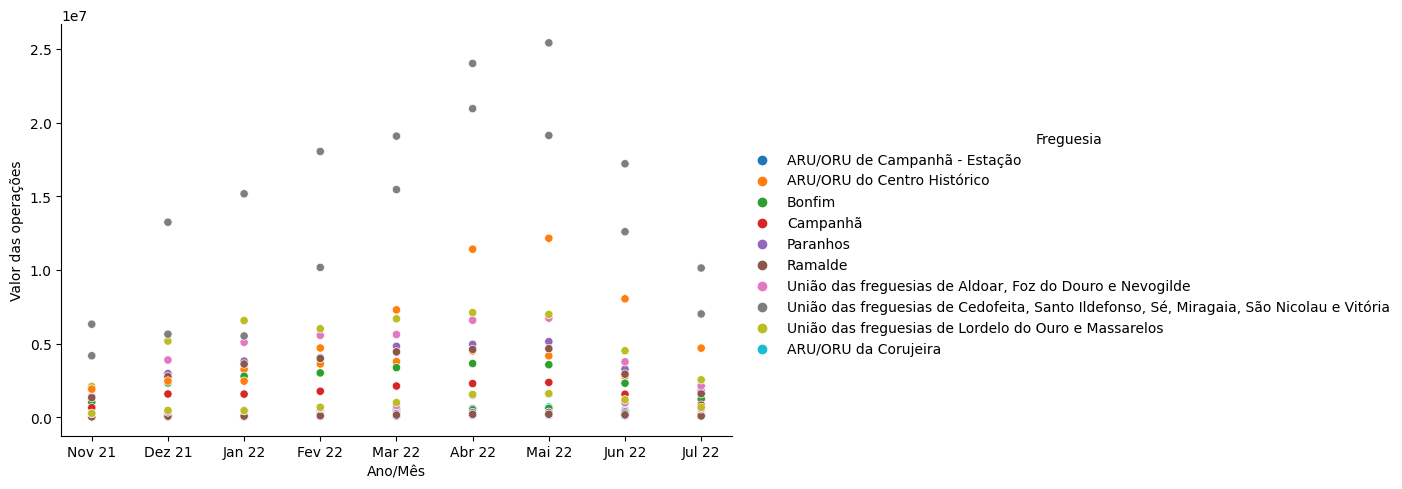

In [17]:
sns.relplot(data=result[result["Setor"]=="Restaurantes"], x="Ano/Mês", y="Valor das operações", hue="Freguesia", aspect=1.61)

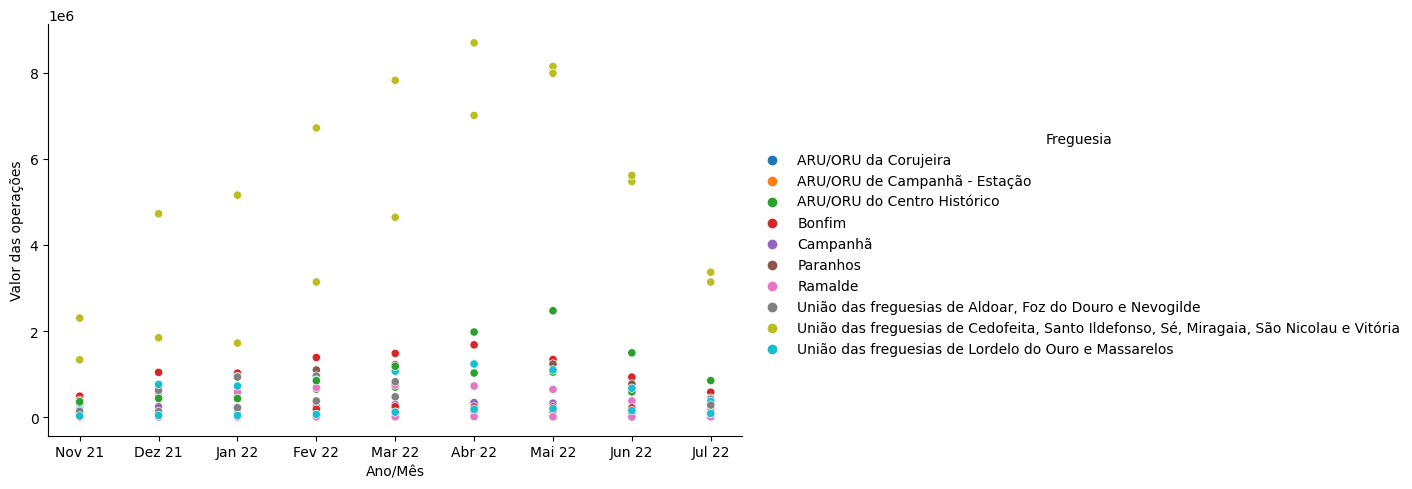

In [18]:
sns.relplot(data=result[result["Setor"]=="Bares, Cafés e Similares"], x="Ano/Mês", y="Valor das operações", hue="Freguesia", aspect=1.61)

In [19]:
result["Setor"].value_counts().head(20)

Bares, Cafés e Similares    172
Restaurantes                168
Name: Setor, dtype: int64

In [20]:
result[result["origin"]=="non-local"].groupby(["Setor", "Freguesia"]).sum().sort_values("Valor das operações", ascending = False).head(20)

index  \
Setor                    Freguesia                                                   
Restaurantes             União das freguesias de Cedofeita, Santo Ildefo...  30069   
                         ARU/ORU do Centro Histórico                         29583   
Bares, Cafés e Similares União das freguesias de Cedofeita, Santo Ildefo...  20331   
                         ARU/ORU do Centro Histórico                         19872   
Restaurantes             União das freguesias de Lordelo do Ouro e Massa...  30150   
                         União das freguesias de Aldoar, Foz do Douro e ...  29988   
                         Bonfim                                              29664   
                         Paranhos                                            29826   
Bares, Cafés e Similares União das freguesias de Aldoar, Foz do Douro e ...  13509   
                         Bonfim                                              19953   
Restaurantes             Campanhã                                            29745   
                         Ramalde                                             29907   
Bares, Cafés e Similares União das freguesias de Lordelo do Ouro e Massa...  20412   
Restaurantes             ARU/ORU de Campanhã - Estação                       29502   
Bares, Cafés e Similares Paranhos                                            20115   
Restaurantes             ARU/ORU da Corujeira                                 9816   
Bares, Cafés e Similares ARU/ORU da Corujeira                                17524   
                         ARU/ORU de Campanhã - Estação                       19791   
                         Ramalde                                             20196   
                         Campanhã                                            20034   

                                                                             Nº de operações  \
Setor                    Freguesia                                                             
Restaurantes             União das freguesias de Cedofeita, Santo Ildefo...          3667951   
                         ARU/ORU do Centro Histórico                                 1824742   
Bares, Cafés e Similares União das freguesias de Cedofeita, Santo Ildefo...          2020198   
                         ARU/ORU do Centro Histórico                                  524291   
Restaurantes             União das freguesias de Lordelo do Ouro e Massa...           243498   
                         União das freguesias de Aldoar, Foz do Douro e ...           141023   
                         Bonfim                                                        80321   
                         Paranhos                                                      68557   
Bares, Cafés e Similares União das freguesias de Aldoar, Foz do Douro e ...            54256   
                         Bonfim                                                        54426   
Restaurantes             Campanhã                                                      98061   
                         Ramalde                                                       43797   
Bares, Cafés e Similares União das freguesias de Lordelo do Ouro e Massa...            60094   
Restaurantes             ARU/ORU de Campanhã - Estação                                 49876   
Bares, Cafés e Similares Paranhos                                                      22163   
Restaurantes             ARU/ORU da Corujeira                                           7237   
Bares, Cafés e Similares ARU/ORU da Corujeira                                           4482   
                         ARU/ORU de Campanhã - Estação                                  5065   
                         Ramalde                                                        2156   
                         Campanhã                                                       3846   

                                                                       

In [21]:
result[result["origin"]=="non-local"].groupby(["Setor", "Freguesia"]).mean().sort_values("Valor das operações", ascending = False).head(20)

index  \
Setor                    Freguesia                                                    
Restaurantes             União das freguesias de Cedofeita, Santo Ildefo...  3341.0   
                         ARU/ORU do Centro Histórico                         3287.0   
Bares, Cafés e Similares União das freguesias de Cedofeita, Santo Ildefo...  2259.0   
                         ARU/ORU do Centro Histórico                         2208.0   
Restaurantes             União das freguesias de Lordelo do Ouro e Massa...  3350.0   
                         União das freguesias de Aldoar, Foz do Douro e ...  3332.0   
                         Bonfim                                              3296.0   
Bares, Cafés e Similares União das freguesias de Aldoar, Foz do Douro e ...  2251.5   
Restaurantes             Paranhos                                            3314.0   
Bares, Cafés e Similares Bonfim                                              2217.0   
Restaurantes             Campanhã                                            3305.0   
                         Ramalde                                             3323.0   
Bares, Cafés e Similares União das freguesias de Lordelo do Ouro e Massa...  2268.0   
Restaurantes             ARU/ORU da Corujeira                                3272.0   
                         ARU/ORU de Campanhã - Estação                       3278.0   
Bares, Cafés e Similares Paranhos                                            2235.0   
                         ARU/ORU da Corujeira                                2190.5   
                         ARU/ORU de Campanhã - Estação                       2199.0   
                         Ramalde                                             2244.0   
                         Campanhã                                            2226.0   

                                                                             Nº de operações  \
Setor                    Freguesia                                                             
Restaurantes             União das freguesias de Cedofeita, Santo Ildefo...    407550.111111   
                         ARU/ORU do Centro Histórico                           202749.111111   
Bares, Cafés e Similares União das freguesias de Cedofeita, Santo Ildefo...    224466.444444   
                         ARU/ORU do Centro Histórico                            58254.555556   
Restaurantes             União das freguesias de Lordelo do Ouro e Massa...     27055.333333   
                         União das freguesias de Aldoar, Foz do Douro e ...     15669.222222   
                         Bonfim                                                  8924.555556   
Bares, Cafés e Similares União das freguesias de Aldoar, Foz do Douro e ...      9042.666667   
Restaurantes             Paranhos                                                7617.444444   
Bares, Cafés e Similares Bonfim                                                  6047.333333   
Restaurantes             Campanhã                                               10895.666667   
                         Ramalde                                                 4866.333333   
Bares, Cafés e Similares União das freguesias de Lordelo do Ouro e Massa...      6677.111111   
Restaurantes             ARU/ORU da Corujeira                                    2412.333333   
                         ARU/ORU de Campanhã - Estação                           5541.777778   
Bares, Cafés e Similares Paranhos                                                2462.555556   
                         ARU/ORU da Corujeira                                     560.250000   
                         ARU/ORU de Campanhã - Estação                            562.777778   
                         Ramalde                                                  239.555556   
                         Campanhã                                                 427.333333   

                                                  

In [22]:
result["Freguesia"].value_counts()

ARU/ORU de Campanhã - Estação                                                              36
ARU/ORU do Centro Histórico                                                                36
Bonfim                                                                                     36
Campanhã                                                                                   36
Paranhos                                                                                   36
Ramalde                                                                                    36
União das freguesias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória    36
União das freguesias de Lordelo do Ouro e Massarelos                                       36
União das freguesias de Aldoar, Foz do Douro e Nevogilde                                   30
ARU/ORU da Corujeira                                                                       22
Name: Freguesia, dtype: int64

In [23]:
result = result[result['origin']=="non-local"].copy().sort_values(["Ano", "Mês"])

In [24]:
result

,index,origin,Setor,Freguesia,Ano/Mês,Nº de operações,Valor das operações,prob,Mês,Ano
177,2194,non-local,"Bares, Cafés e Similares",ARU/ORU da Corujeira,Nov 21,723,17019.33,0.143339,11,21
186,2203,non-local,"Bares, Cafés e Similares",ARU/ORU de Campanhã - Estação,Nov 21,113,792.18,0.017468,11,21
195,2212,non-local,"Bares, Cafés e Similares",ARU/ORU do Centro Histórico,Nov 21,20093,354681.57,0.449448,11,21
204,2221,non-local,"Bares, Cafés e Similares",Bonfim,Nov 21,1904,67522.98,0.064746,11,21
213,2230,non-local,"Bares, Cafés e Similares",Campanhã,Nov 21,101,956.21,0.009383,11,21
...,...,...,...,...,...,...,...,...,...,...
299,3314,non-local,Restaurantes,Paranhos,Jul 22,4701,150988.89,0.043808,7,22
308,3323,non-local,Restaurantes,Ramalde,Jul 22,3151,96133.59,0.043735,7,22
317,3332,non-local,Restaurantes,"União das freguesias de Aldoar, Foz do Douro e...",Jul 22,10886,572480.76,0.149074,7,22
326,3341,non-local,Restaurantes,"União das freguesias de Cedofeita, Santo Ildef...",Jul 22,313839,10134730.00,0.456407,7,22


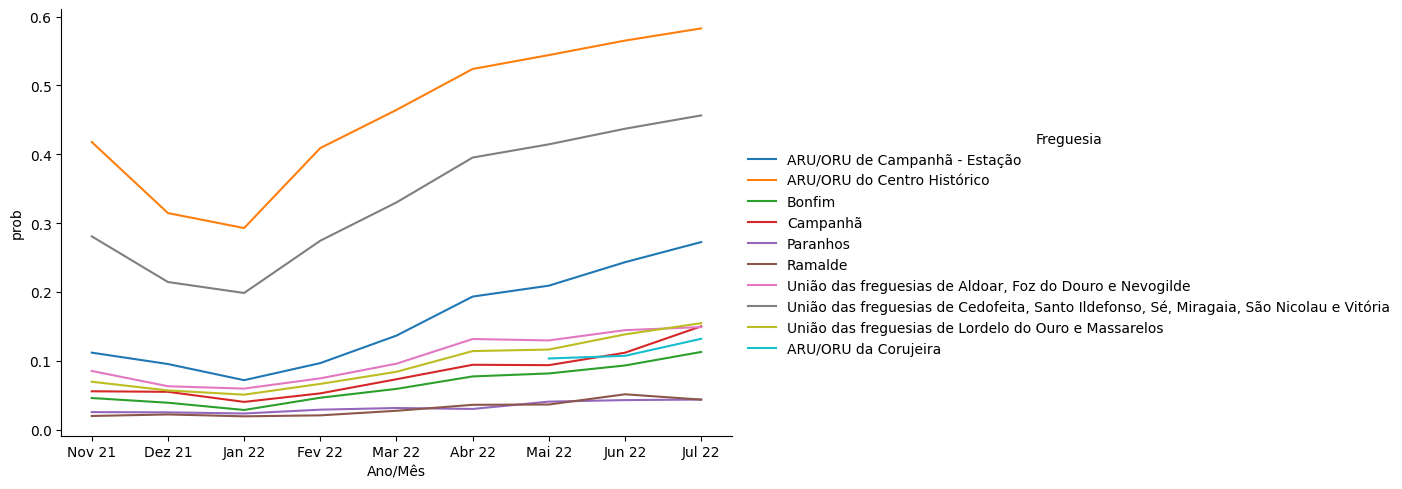

In [27]:
sns.relplot(data=result[result["Setor"]=="Restaurantes"], x="Ano/Mês", y="prob", hue="Freguesia", aspect=1.61, kind="line")

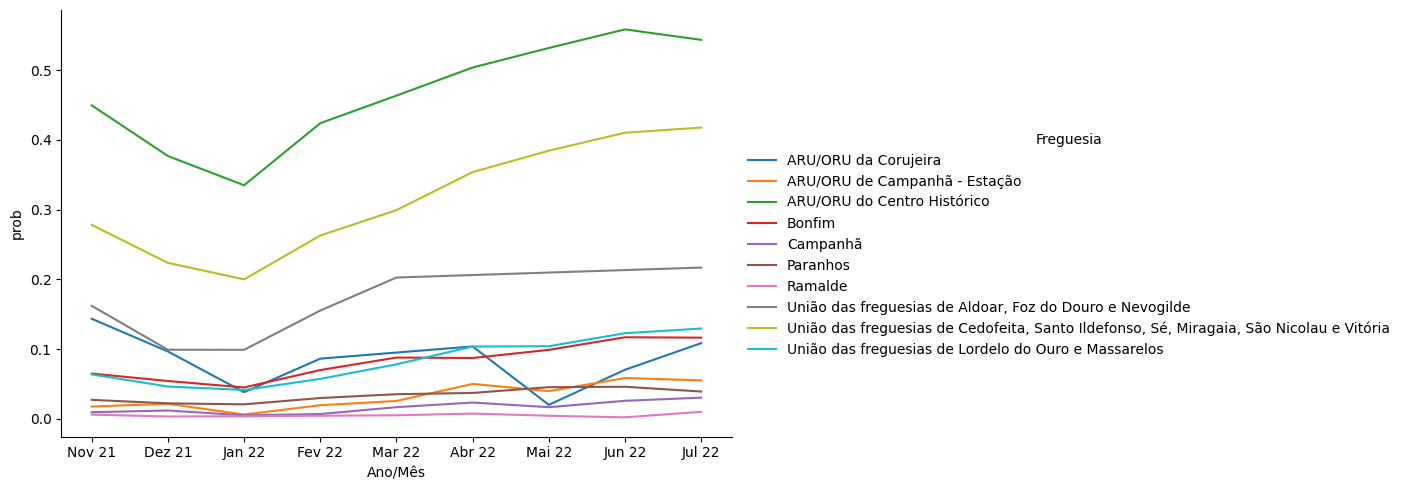

In [28]:
sns.relplot(data=result[result["Setor"]=="Bares, Cafés e Similares"], x="Ano/Mês", y="prob", hue="Freguesia", aspect=1.61, kind="line")

In [ ]:
result.to_csv("data/interim/prob_turism.csv")